In [1]:
import os
import math
import numpy as np
from astrodendro import Dendrogram, pp_catalog, ppv_catalog
from astrodendro.analysis import PPStatistic
from scipy import linspace, polyval, polyfit, sqrt, stats, randn
from astropy.io import fits
from astropy import units as u
from astropy import constants as con
from astropy.coordinates import SkyCoord
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import aplpy
from astropy.io.fits import getdata
from astropy import wcs
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

/Users/shjiao/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [2]:
%matplotlib inline

Show M31 SCUBA2 850 um image and combined image

INFO: Auto-setting vmin to -2.053e-01 [aplpy.core]
INFO: Auto-setting vmax to  2.178e-01 [aplpy.core]
INFO: Setting slices=[0] [aplpy.core]
INFO: Auto-setting vmin to -1.373e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.370e+00 [aplpy.core]


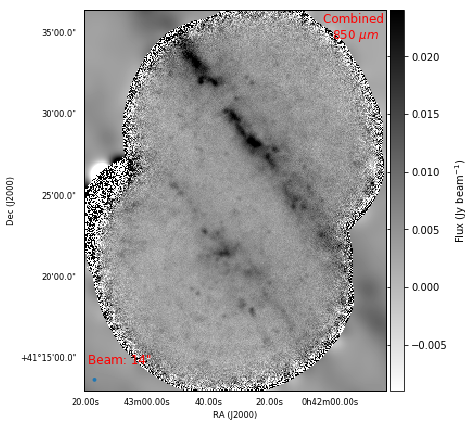

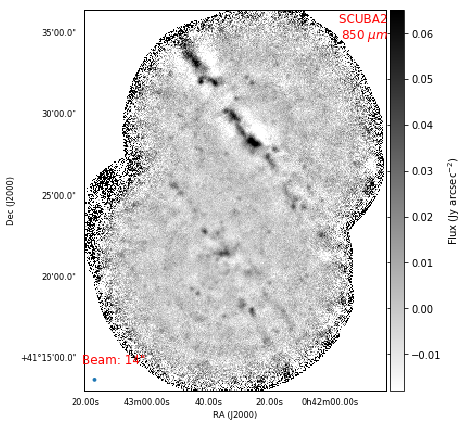

In [47]:
f_850com = aplpy.FITSFigure('/Users/shjiao/desktop/combined850.fits', figsize=(7,7))
f_850com.show_grayscale()
f_850com.add_colorbar()
f_850com.colorbar.show()
f_850com.recenter(10.6303042,41.41090276,width=0.31,height=0.39)
f_850com.colorbar.set_location('right')
f_850com.colorbar.set_axis_label_text(r'Flux (Jy beam$^{-1}$)')
f_850com.add_label(0.9,0.95, 'Combined \n850 $\mu m$ ', color='red', relative=True, size='large',layer='source')
f_850com.show_colorscale(vmin=-0.003*3,vmax=0.024,cmap='gist_yarg',stretch='linear')
f_850com.add_beam(major=14.*u.arcsecond,minor=14.*u.arcsecond,angle=0.0)
f_850com.add_label(0.12, 0.08, 'Beam: 14\"', relative=True, size='large', layer='title',color='red')
f_850com.tick_labels.set_font(size='small')
f_850com.axis_labels.set_font(size='small')

f_850 = aplpy.FITSFigure('/Users/shjiao/desktop/check/m31_850/m31_850.conv.fits', figsize=(7,7))
f_850.show_grayscale()
f_850.add_colorbar()
f_850.colorbar.show()
f_850.recenter(10.6303042,41.41090276,width=0.31,height=0.39)
f_850.colorbar.set_location('right')
f_850.colorbar.set_axis_label_text(r'Flux (Jy arcsec$^{-2}$)')
f_850.add_label(0.93,0.95, 'SCUBA2 \n850 $\mu m$ ', color='red', relative=True, size='large',layer='source')
f_850.show_colorscale(vmin=-0.006*3,vmax=0.065,cmap='gist_yarg',stretch='linear')
f_850.add_beam(major=14.*u.arcsecond,minor=14.*u.arcsecond,angle=0.0)
f_850.add_label(0.1, 0.08, 'Beam: 14\"', relative=True, size='large', layer='title',color='red')
f_850.tick_labels.set_font(size='small')
f_850.axis_labels.set_font(size='small')

# Unsharp Masking

Smooth the image to lower resolution and then do the subtracton. 
Smooth SCUBA2 850 um image to 30", 1' and 2'.

In [3]:
from astropy.io import fits
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib
from astropy import units as u
import aplpy
import AG_fft_tools as fft_tools
from astropy.convolution import convolve, Gaussian2DKernel, Tophat2DKernel 
from astropy.modeling.models import Gaussian2D

In [5]:
#import SCUBA2 850 um map
beam_file='/Users/shjiao/desktop/check/m31_850/m31_850.conv.fits'
hdu1=fits.open(beam_file)
data1 = hdu1[0].data[0]
data1 = np.nan_to_num(data1)
header = hdu1[0].header

nra = header['naxis1']
ndec = header['naxis2']
header.remove('CTYPE3')
header.remove('CRVAL3')
header.remove('CDELT3')
header.remove('CRPIX3')
header.remove('CUNIT3')
header.remove('NAXIS3')
header.remove('LBOUND3')
header['NAXIS']=2

target_resolution1 = 30.
target_resolution2 = 60.
target_resolution3 = 120.
native_beamsize = 14.
pixel_size = 4.0

FWHM_TO_SIGMA = 1./np.sqrt(8*np.log(2))

#smooth to 30"
kernel_size1=((target_resolution1*FWHM_TO_SIGMA)**2-(native_beamsize*FWHM_TO_SIGMA)**2)**0.5
pixel_n1 = kernel_size1/pixel_size
gauss_kernel1 =Gaussian2DKernel(pixel_n1)
smoothed_data_gauss1 = convolve(data1, gauss_kernel1,normalize_kernel=True)

#save fits file
outpath1 = r'/Users/shjiao/desktop/check/m31_850/scuba2_m31_sm1.fits'

fits.writeto(outpath1,smoothed_data_gauss1,header=header) 
fits.setval(outpath1,'BMAJ',value=target_resolution1/3600.)  
fits.setval(outpath1,'BMIN',value=target_resolution1/3600.) 

#smooth to 60"
kernel_size2=((target_resolution2*FWHM_TO_SIGMA)**2-(native_beamsize*FWHM_TO_SIGMA)**2)**0.5
pixel_n2 = kernel_size2/pixel_size
gauss_kernel2 =Gaussian2DKernel(pixel_n2)
smoothed_data_gauss2 = convolve(data1, gauss_kernel2,normalize_kernel=True)

#save fits file
outpath2 = r'/Users/shjiao/desktop/check/m31_850/scuba2_m31_sm2.fits'

fits.writeto(outpath2,smoothed_data_gauss2,header=header) 
fits.setval(outpath2,'BMAJ',value=target_resolution2/3600.)  
fits.setval(outpath2,'BMIN',value=target_resolution2/3600.) 

#smooth to 120"
kernel_size3=((target_resolution3*FWHM_TO_SIGMA)**2-(native_beamsize*FWHM_TO_SIGMA)**2)**0.5
pixel_n3 = kernel_size3/pixel_size
gauss_kernel3 =Gaussian2DKernel(pixel_n3)
smoothed_data_gauss3 = convolve(data1, gauss_kernel3,normalize_kernel=True)

#save fits file
outpath3 = r'/Users/shjiao/desktop/check/m31_850/scuba2_m31_sm3.fits'

fits.writeto(outpath3,smoothed_data_gauss3,header=header) 
fits.setval(outpath3,'BMAJ',value=target_resolution3/3600.)  
fits.setval(outpath3,'BMIN',value=target_resolution3/3600.) 

Show the smoothed images

INFO: Auto-setting vmin to -3.315e-01 [aplpy.core]
INFO: Auto-setting vmax to  2.821e-01 [aplpy.core]
INFO: Auto-setting vmin to -2.067e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.672e-01 [aplpy.core]
INFO: Auto-setting vmin to -7.076e-02 [aplpy.core]
INFO: Auto-setting vmax to  5.329e-02 [aplpy.core]


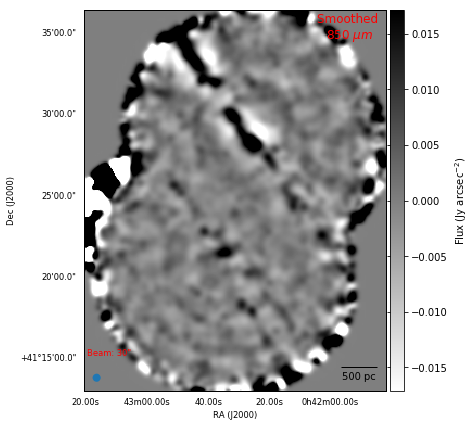

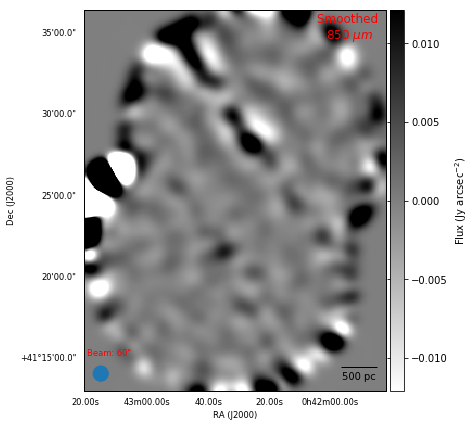

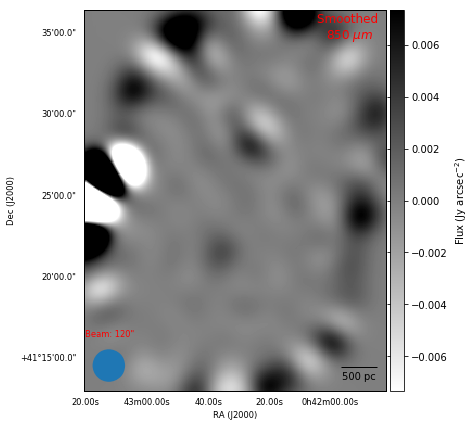

In [48]:
f_sm1 = aplpy.FITSFigure('/Users/shjiao/desktop/check/m31_850/scuba2_m31_sm1.fits', figsize=(7,7))
f_sm1.show_grayscale()
f_sm1.add_colorbar()
f_sm1.colorbar.show()
f_sm1.recenter(10.6303042,41.41090276,width=0.31,height=0.39)
f_sm1.colorbar.set_location('right')
f_sm1.colorbar.set_axis_label_text(r'Flux (Jy arcsec$^{-2}$)')
f_sm1.add_label(0.88,0.95, 'Smoothed \n850 $\mu m$ ', color='red', relative=True, size='large',layer='source')
f_sm1.show_colorscale(vmin=-0.01710669,vmax=0.01710669,cmap='gist_yarg',stretch='linear')
f_sm1.add_beam(major=30.*u.arcsecond,minor=30.*u.arcsecond,angle=0.0)
f_sm1.add_label(0.085, 0.1, 'Beam: 30\"', relative=True, size='small', layer='title',color='red')
f_sm1.tick_labels.set_font(size='small')
f_sm1.axis_labels.set_font(size='small')
f_sm1.add_scalebar(0.0367281,"500 pc",color='black', corner='bottom right')

f_sm2 = aplpy.FITSFigure('/Users/shjiao/desktop/check/m31_850/scuba2_m31_sm2.fits', figsize=(7,7))
f_sm2.show_grayscale()
f_sm2.add_colorbar()
f_sm2.colorbar.show()
f_sm2.recenter(10.6303042,41.41090276,width=0.31,height=0.39)
f_sm2.colorbar.set_location('right')
f_sm2.colorbar.set_axis_label_text(r'Flux (Jy arcsec$^{-2}$)')
f_sm2.add_label(0.88,0.95, 'Smoothed \n850 $\mu m$ ', color='red', relative=True, size='large',layer='source')
f_sm2.show_colorscale(vmin=-0.012109268,vmax=0.012109268,cmap='gist_yarg',stretch='linear')
f_sm2.add_beam(major=60.*u.arcsecond,minor=60.*u.arcsecond,angle=0.0)
f_sm2.add_label(0.085, 0.1, 'Beam: 60\"', relative=True, size='small', layer='title',color='red')
f_sm2.tick_labels.set_font(size='small')
f_sm2.axis_labels.set_font(size='small')
f_sm2.add_scalebar(0.0367281,"500 pc",color='black', corner='bottom right')

f_sm3 = aplpy.FITSFigure('/Users/shjiao/desktop/check/m31_850/scuba2_m31_sm3.fits', figsize=(7,7))
f_sm3.show_grayscale()
f_sm3.add_colorbar()
f_sm3.colorbar.show()
f_sm3.recenter(10.6303042,41.41090276,width=0.31,height=0.39)
f_sm3.colorbar.set_location('right')
f_sm3.colorbar.set_axis_label_text(r'Flux (Jy arcsec$^{-2}$)')
f_sm3.add_label(0.88,0.95, 'Smoothed \n850 $\mu m$ ', color='red', relative=True, size='large',layer='source')
f_sm3.show_colorscale(vmin=-0.0073290113,vmax=0.0073290113,cmap='gist_yarg',stretch='linear')
f_sm3.add_beam(major=120.*u.arcsecond,minor=120.*u.arcsecond,angle=0.0)
f_sm3.add_label(0.085, 0.15, 'Beam: 120\"', relative=True, size='small', layer='title',color='red')
f_sm3.tick_labels.set_font(size='small')
f_sm3.axis_labels.set_font(size='small')
f_sm3.add_scalebar(0.0367281,"500 pc",color='black', corner='bottom right')

Subtraction

In [49]:
#import SCUBA2 850 um image
scu_file='/Users/shjiao/desktop/check/m31_850/m31_850.conv.fits'
hdu1=fits.open(scu_file)
data1 = hdu1[0].data[0]
#import scuba2 850 um image
beam_file='/Users/shjiao/desktop/check/m31_850/m31_850.conv.fits'
hdu2=fits.open(beam_file)
data2 = hdu2[0].data[0]

#30"
unsharped1=data1-smoothed_data_gauss1
for i in range(0,data2.shape[0]):
    for j in range(0,data2.shape[1]):
        if np.isnan(data2[i][j]):
            unsharped1[i][j]=np.NAN

outpath1 = r'/Users/shjiao/desktop/check/m31_850/scuba2_m31_unsharped1.fits'
fits.writeto(outpath1,unsharped1,header=header)

#60"
unsharped2=data1-smoothed_data_gauss2
for i in range(0,data2.shape[0]):
    for j in range(0,data2.shape[1]):
        if np.isnan(data2[i][j]):
            unsharped2[i][j]=np.NAN

outpath2 = r'/Users/shjiao/desktop/check/m31_850/scuba2_m31_unsharped2.fits'
fits.writeto(outpath2,unsharped2,header=header)

#120"
unsharped3=data1-smoothed_data_gauss3
for i in range(0,data2.shape[0]):
    for j in range(0,data2.shape[1]):
        if np.isnan(data2[i][j]):
            unsharped3[i][j]=np.NAN

outpath3 = r'/Users/shjiao/desktop/check/m31_850/scuba2_m31_unsharped3.fits'
fits.writeto(outpath3,unsharped3,header=header)

Show the unsharp masking images

INFO: Setting slices=[0] [aplpy.core]
INFO: Auto-setting vmin to -1.373e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.370e+00 [aplpy.core]
INFO: Auto-setting vmin to -1.265e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.280e+00 [aplpy.core]
INFO: Auto-setting vmin to -1.314e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.311e+00 [aplpy.core]
INFO: Auto-setting vmin to -1.358e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.365e+00 [aplpy.core]


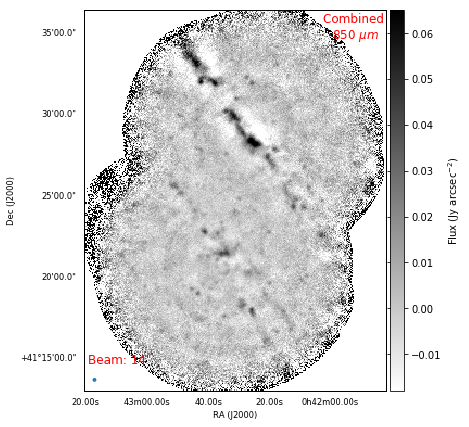

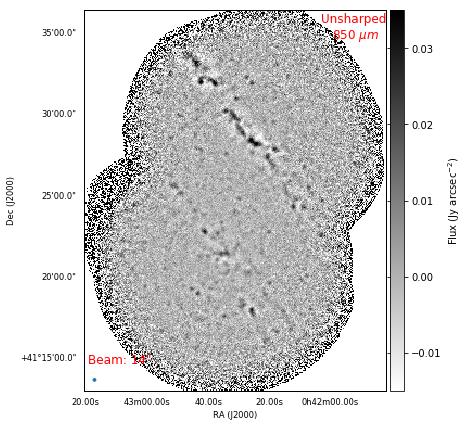

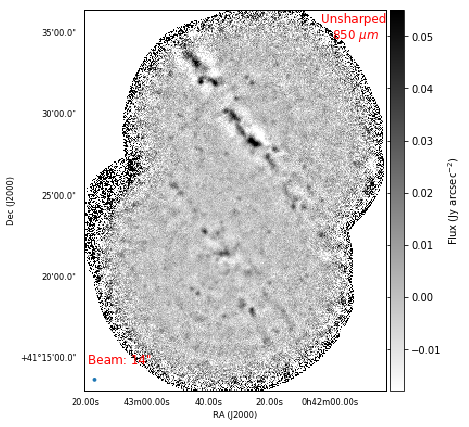

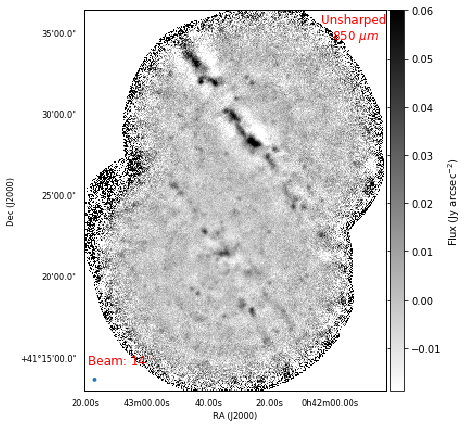

In [53]:
f_850com = aplpy.FITSFigure('/Users/shjiao/desktop/check/m31_850/m31_850.conv.fits', figsize=(7,7))
f_850com.show_grayscale()
f_850com.add_colorbar()
f_850com.colorbar.show()
f_850com.recenter(10.6303042,41.41090276,width=0.31,height=0.39)
f_850com.colorbar.set_location('right')
f_850com.colorbar.set_axis_label_text(r'Flux (Jy arcsec$^{-2}$)')
f_850com.add_label(0.9,0.95, 'Combined \n850 $\mu m$ ', color='red', relative=True, size='large',layer='source')
f_850com.show_colorscale(vmin=-0.006*3,vmax=0.065,cmap='gist_yarg',stretch='linear')
f_850com.add_beam(major=14.*u.arcsecond,minor=14.*u.arcsecond,angle=0.0)
f_850com.add_label(0.12, 0.08, 'Beam: 14\"', relative=True, size='large', layer='title',color='red')
f_850com.tick_labels.set_font(size='small')
f_850com.axis_labels.set_font(size='small')

f_850com = aplpy.FITSFigure('/Users/shjiao/desktop/check/m31_850/scuba2_m31_unsharped1.fits', figsize=(7,7))
f_850com.show_grayscale()
f_850com.add_colorbar()
f_850com.colorbar.show()
f_850com.recenter(10.6303042,41.41090276,width=0.31,height=0.39)
f_850com.colorbar.set_location('right')
f_850com.colorbar.set_axis_label_text(r'Flux (Jy arcsec$^{-2}$)')
f_850com.add_label(0.9,0.95, 'Unsharped \n850 $\mu m$ ', color='red', relative=True, size='large',layer='source')
f_850com.show_colorscale(vmin=-0.005*3,vmax=0.035,cmap='gist_yarg',stretch='linear')
f_850com.add_beam(major=14.*u.arcsecond,minor=14.*u.arcsecond,angle=0.0)
f_850com.add_label(0.12, 0.08, 'Beam: 14\"', relative=True, size='large', layer='title',color='red')
f_850com.tick_labels.set_font(size='small')
f_850com.axis_labels.set_font(size='small')

f_850com = aplpy.FITSFigure('/Users/shjiao/desktop/check/m31_850/scuba2_m31_unsharped2.fits', figsize=(7,7))
f_850com.show_grayscale()
f_850com.add_colorbar()
f_850com.colorbar.show()
f_850com.recenter(10.6303042,41.41090276,width=0.31,height=0.39)
f_850com.colorbar.set_location('right')
f_850com.colorbar.set_axis_label_text(r'Flux (Jy arcsec$^{-2}$)')
f_850com.add_label(0.9,0.95, 'Unsharped \n850 $\mu m$ ', color='red', relative=True, size='large',layer='source')
f_850com.show_colorscale(vmin=-0.006*3,vmax=0.055,cmap='gist_yarg',stretch='linear')
f_850com.add_beam(major=14.*u.arcsecond,minor=14.*u.arcsecond,angle=0.0)
f_850com.add_label(0.12, 0.08, 'Beam: 14\"', relative=True, size='large', layer='title',color='red')
f_850com.tick_labels.set_font(size='small')
f_850com.axis_labels.set_font(size='small')

f_850com = aplpy.FITSFigure('/Users/shjiao/desktop/check/m31_850/scuba2_m31_unsharped3.fits', figsize=(7,7))
f_850com.show_grayscale()
f_850com.add_colorbar()
f_850com.colorbar.show()
f_850com.recenter(10.6303042,41.41090276,width=0.31,height=0.39)
f_850com.colorbar.set_location('right')
f_850com.colorbar.set_axis_label_text(r'Flux (Jy arcsec$^{-2}$)')
f_850com.add_label(0.9,0.95, 'Unsharped \n850 $\mu m$ ', color='red', relative=True, size='large',layer='source')
f_850com.show_colorscale(vmin=-0.0063*3,vmax=0.06,cmap='gist_yarg',stretch='linear')
f_850com.add_beam(major=14.*u.arcsecond,minor=14.*u.arcsecond,angle=0.0)
f_850com.add_label(0.12, 0.08, 'Beam: 14\"', relative=True, size='large', layer='title',color='red')
f_850com.tick_labels.set_font(size='small')
f_850com.axis_labels.set_font(size='small')

Using Dendrogram to identify point sources

In [6]:
from skimage.morphology import disk,erosion,opening

In [114]:
# load FITS image
unsharp_file='/Users/shjiao/desktop/check/m31_850/scuba2_m31_unsharped1.fits'
hdu_us=fits.open(unsharp_file)
data1 = hdu_us[0].data
nheader = hdu_us[0].header

mask=np.isfinite(data1)
mask1=erosion(mask, disk(30))
f = data1/mask1
NH2 = f

rms = 0.004  # mJy/arcsec**2
min_npix = 12.0
# calculate dendrogram
d_sec = Dendrogram.compute(
                        f, 
                        min_value = rms*1.5, 
                        min_delta = rms*1.5, 
                        min_npix  = min_npix,
                        wcs = wcs
                       )

# save the dendrogram
#d_sec.save_to('/Users/shjiao/desktop/check/m31_850/m31_dendrogram.erosion.hdf5')

# a summary of dendrogram structure
print d_sec.trunk 

/Users/shjiao/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in divide
  if __name__ == '__main__':


[<Structure type=branch idx=2>, <Structure type=leaf idx=3>, <Structure type=leaf idx=4>, <Structure type=leaf idx=7>, <Structure type=leaf idx=5>, <Structure type=leaf idx=6>, <Structure type=leaf idx=8>, <Structure type=leaf idx=9>, <Structure type=leaf idx=10>, <Structure type=branch idx=13>, <Structure type=leaf idx=15>, <Structure type=leaf idx=14>, <Structure type=leaf idx=16>, <Structure type=leaf idx=18>, <Structure type=leaf idx=19>, <Structure type=leaf idx=17>, <Structure type=leaf idx=20>, <Structure type=leaf idx=21>, <Structure type=leaf idx=22>, <Structure type=leaf idx=23>, <Structure type=leaf idx=24>, <Structure type=leaf idx=25>, <Structure type=leaf idx=26>, <Structure type=leaf idx=28>, <Structure type=leaf idx=29>, <Structure type=leaf idx=27>, <Structure type=leaf idx=30>, <Structure type=leaf idx=31>, <Structure type=leaf idx=32>, <Structure type=leaf idx=35>, <Structure type=leaf idx=33>, <Structure type=branch idx=36>, <Structure type=leaf idx=38>, <Structure 

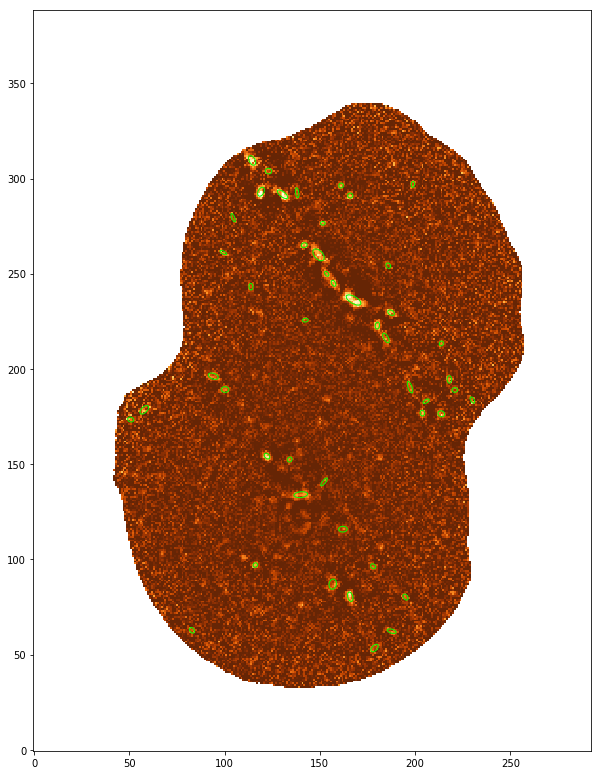

In [117]:
fig = plt.figure(figsize=(10,15))
p3 = d_sec.plotter()
ax1 = fig.add_subplot(1,1,1)
ax1.imshow((f), origin='lower', interpolation='nearest',
          cmap=plt.cm.YlOrBr_r,vmin=-0.0018802518,vmax=0.043593604)
NH2 = data1
NH2_mean = []
for i,leaf in enumerate(d_sec.leaves):
    NH2_mean= np.append(NH2_mean,np.nanmean(NH2[leaf.indices()[0],leaf.indices()[1]]))          
          
for i,leaf in enumerate(d_sec.leaves):
    s = PPStatistic(leaf)
    ellipse = s.to_mpl_ellipse(edgecolor='lime', facecolor='none')
    ax1.add_patch(ellipse)

In [22]:
# load FITS image
unsharp2_file='/Users/shjiao/desktop/check/m31_850/scuba2_m31_unsharped2.fits'
hdu_us2=fits.open(unsharp2_file)
data2 = hdu_us2[0].data

mask=np.isfinite(data2)
mask1=erosion(mask, disk(30))
f = data2/mask1
NH2 = f

rms = 0.004  # mJy/arcsec**2
min_npix = 12.0
# calculate dendrogram
d = Dendrogram.compute(
                        f, 
                        min_value = rms*1.7, 
                        min_delta = rms*1.5, 
                        min_npix  = min_npix,
                        wcs = wcs
                       )

# save the dendrogram
#d_sec.save_to('/Users/shjiao/desktop/check/m31_850/m31_dendrogram.erosion.hdf5')

# a summary of dendrogram structure
print d.trunk 

/Users/shjiao/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in divide
  
/Users/shjiao/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/astrodendro/dendrogram.py:177: RuntimeWarning: invalid value encountered in greater
  keep = self.data > min_value


[<Structure type=leaf idx=0>, <Structure type=leaf idx=1>, <Structure type=leaf idx=2>, <Structure type=leaf idx=3>, <Structure type=leaf idx=5>, <Structure type=leaf idx=6>, <Structure type=leaf idx=4>, <Structure type=leaf idx=7>, <Structure type=leaf idx=8>, <Structure type=leaf idx=9>, <Structure type=branch idx=15>, <Structure type=leaf idx=12>, <Structure type=leaf idx=14>, <Structure type=leaf idx=10>, <Structure type=leaf idx=16>, <Structure type=leaf idx=18>, <Structure type=leaf idx=17>, <Structure type=leaf idx=20>, <Structure type=leaf idx=19>, <Structure type=leaf idx=23>, <Structure type=leaf idx=21>, <Structure type=leaf idx=22>, <Structure type=leaf idx=24>, <Structure type=leaf idx=26>, <Structure type=leaf idx=25>, <Structure type=leaf idx=27>, <Structure type=leaf idx=28>, <Structure type=leaf idx=29>, <Structure type=leaf idx=30>, <Structure type=leaf idx=31>, <Structure type=leaf idx=32>, <Structure type=leaf idx=34>, <Structure type=leaf idx=35>, <Structure type=l

/Users/shjiao/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/astrodendro/pruning.py:89: RuntimeWarning: invalid value encountered in double_scalars
  return (structure.vmax - structure.vmin) >= delta


In [126]:
# making dendrogram structurea a catelogue,
# and print it
metadata = {}
metadata['data_unit'] = u.Jy / u.beam
metadata['spatial_scale'] =  4.0 * u.arcsec # this means the pixel size
metadata['beam_major'] =  14.0 * u.arcsec
metadata['beam_minor'] =  14.0 * u.arcsec

distance = 780.0*1000.0 # parsec
parsec_to_aU = 206264.806247096

print  'CDELT : ', metadata['spatial_scale'], "\n"
print  'BMAJ : ', metadata['beam_major'] 
print  'BMIN : ', metadata['beam_minor'], "\n\n" 
print  'minimum leaf size : ', \
        metadata['spatial_scale'] * min_npix * distance / parsec_to_aU, "[parsec] \n"
print  'minimum leaf area : ', \
        metadata['spatial_scale'] * metadata['spatial_scale'] * min_npix, "\n"

cat = pp_catalog(d, metadata, verbose=False)
cat.pprint(show_unit=True, max_lines=120)

import csv

# write it
with open('/Users/shjiao/desktop/check/m31_850/unsharp_file.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    [writer.writerow(r) for r in cat]

CDELT :  4.0 arcsec 

BMAJ :  14.0 arcsec
BMIN :  14.0 arcsec 


minimum leaf size :  181.514242207 arcsec [parsec] 

minimum leaf area :  192.0 arcsec2 

_idx  area_ellipse area_exact ...     radius        x_cen         y_cen    
        arcsec2     arcsec2   ...     arcsec         pix           pix     
---- ------------- ---------- ... ------------- ------------- -------------
   0           0.0     3376.0 ...           0.0           nan           nan
   1           0.0      688.0 ...           0.0           nan           nan
   2 139.236876794      304.0 ... 5.65429116785 114.520071641 47.2764532974
   3 228.164841597      608.0 ... 7.23811358621 178.970394504 53.7815456069
   4           0.0     1472.0 ...           0.0           nan           nan
   5           0.0      592.0 ...           0.0           nan           nan
   6 102.796989368      256.0 ... 4.85837719962  106.12103981 57.8360154633
   7 101.523675905      256.0 ... 4.82819385747  82.745649178 62.7165106231
   8 101.

/Users/shjiao/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/astrodendro/analysis.py:92: RuntimeWarning: invalid value encountered in double_scalars
  return [np.nansum(i * self.values) / m0 for i in self.indices]
/Users/shjiao/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/astrodendro/analysis.py:99: RuntimeWarning: invalid value encountered in divide
  v = self.values / mom0


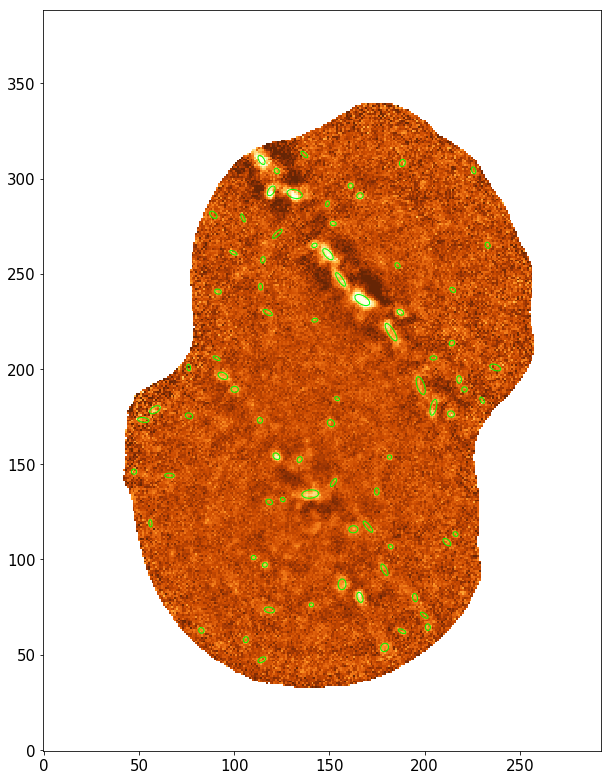

In [24]:
fig = plt.figure(figsize=(10,15))
p3 = d.plotter()
ax1 = fig.add_subplot(1,1,1)
ax1.imshow((f), origin='lower', interpolation='nearest',
          cmap=plt.cm.YlOrBr_r, vmin=-0.018,vmax=0.054)
NH2 = data2
NH2_mean = []
for i,leaf in enumerate(d.leaves):
    NH2_mean= np.append(NH2_mean,np.nanmean(NH2[leaf.indices()[0],leaf.indices()[1]]))          
          
for i,leaf in enumerate(d.leaves):
    s = PPStatistic(leaf)
    ellipse = s.to_mpl_ellipse(edgecolor='lime', facecolor='none')
    ax1.add_patch(ellipse)

# SED fitting

In [3]:
import numpy as np
from astropy.io import fits
from astropy.io import ascii
from astropy.table import Column, Table
from astropy import units as u
from astropy import constants as const
from astropy import wcs
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.optimize import curve_fit
from scipy.integrate import quad

In [4]:
#define constants
h=6.62607e-34 #Planck constant
k=1.38065e-23 #Boltzmann constant
m_H=1.6726e-24 #Proton mass, in g
m_sun=const.M_sun
d=7.07 * u.kpc #distance, 7.07 kpc (Roman-Duval 2009)
k_600=0.0333#k_v in 600 GHz, consider GDR as 100, in cm^2/g (from column 5 of table 1 in Ossenkopf & Henning 1994, often referred to as OH5)
lamda_0=500 #wavelength of v_0, in micron
nu_0=600 * 10**9
mu=2.8 #atomic mass unit of H2
beta=2 #consider beta as 2
c=2.998e8 #light speed


#define SED function, input are lamda(in micronmeter), T and N(in g/cm^2), output is intensity(in MJy/sr)
def SED(lamda,T,N):
	nu=c/(lamda*1e-6)
	k_nu=k_600*(lamda_0/lamda)**beta
	return 2*1e20*h*nu**3/c**2*(1-np.exp(-k_nu*N))/(np.exp(h*nu/k/T)-1)
#input: nu(in Hz), T(in K), N(in g/cm^2)
#output:intensity(in cgs: g/s^2)
def SED2(nu,T,N):
	k_nu=k_600*(nu/nu_0)**beta
	return 2*1e20*h*nu**3/c**2*(1-np.exp(-k_nu*N))/(np.exp(h*nu/k/T)-1)

Show point sources catalog

In [5]:
jps_file='/Users/shjiao/desktop/check/m31_850/unsharp_pho_sec.csv'
jps_cat=ascii.read(jps_file)

In [6]:
im_160='/Users/shjiao/desktop/check/sed/data/regird/pacs160.sm.fitshcongrid.fits'
im_250='/Users/shjiao/desktop/check/sed/data/regird/spire250.conv.fitshcongrid.fits'
im_450='/Users/shjiao/desktop/check/sed/data/regird/combined450.sm.fitshcongrid.fits'
im_850='/Users/shjiao/desktop/check/sed/data/regird/combined850.sm.fits'

#open the input file
hdu_160=fits.open(im_160)
hdu_250=fits.open(im_250)
hdu_450=fits.open(im_450)
hdu_850=fits.open(im_850)

#initialize
name=[]
glon=[]
glat=[]
major=[]
minor=[]
PA=[]
r_eq=[]
SNR_850=[]
T_dust=[]
N_H2=[]
n_H2=[]
sigma=[]
mass=[]
luminosity=[]
l_m=[]

In [7]:
for i in range(len(jps_cat)):
    if jps_cat['col2'][i]>0.0:
        name.append(jps_cat['col1'][i])
        glon.append('%.3f' % jps_cat['col9'][i])
        glat.append('%.3f' % jps_cat['col10'][i])
        major.append(jps_cat['col5'][i])
        minor.append(jps_cat['col6'][i])
        PA.append(jps_cat['col7'][i])
        r_pc=np.sqrt(jps_cat['col5'][i]*jps_cat['col6'][i]) / 3600.0 / 180*np.pi * d.value*1000
        r_eq.append('%.2f' % r_pc)

In [8]:
for i in range(len(jps_cat)):
    if jps_cat['col2'][i]>0.0:
        name.append(jps_cat['col1'][i])
        glon.append('%.3f' % jps_cat['col9'][i])
        glat.append('%.3f' % jps_cat['col10'][i])
        major.append(jps_cat['col5'][i])
        minor.append(jps_cat['col6'][i])
        PA.append(jps_cat['col7'][i])
        r_pc=np.sqrt(jps_cat['col5'][i]*jps_cat['col6'][i]) / 3600.0 / 180*np.pi * d.value*1000
        r_eq.append('%.2f' % r_pc)
        #calcular ellipse size in 14"
        maj_14=major[i]
        min_14=minor[i]
    
        a=maj_14 / 4.
        b=min_14 / 4.
        pa=PA[i] * u.deg
    
        w=wcs.WCS(hdu_850[0].header)
        
        #find pixels that located in the source area
        center_world=np.array([[jps_cat['col9'][i],jps_cat['col10'][i]]])
        center_pixel=np.array([[jps_cat['col9'][i],jps_cat['col10'][i]]])
        x0,y0=center_pixel[0][0],center_pixel[0][1]
    
        y,x=np.indices(hdu_160[0].data.shape)
        inside = ( (((y-y0)*np.sin(pa.cgs.value)+(x-x0)*np.cos(pa.cgs.value))/b)**2 + (((y-y0)*np.cos(pa.cgs.value)-(x-x0)*np.sin(pa.cgs.value))/a)**2 <1 )
    
        #average intensity of the source
        inside_160=hdu_160[0].data[inside].flatten()
        flux_160=np.mean(inside_160[inside_160==inside_160]) * u.Jy / (4. * u.arcsec)**2
        flux_160=flux_160.to_value(u.MJy / u.sr)
        
        y,x=np.indices(hdu_250[0].data.shape)
        inside = ( (((y-y0)*np.sin(pa.cgs.value)+(x-x0)*np.cos(pa.cgs.value))/b)**2 + (((y-y0)*np.cos(pa.cgs.value)-(x-x0)*np.sin(pa.cgs.value))/a)**2 <1 )
    
        #average intensity of the source
        inside_250=hdu_250[0].data[inside].flatten()
        flux_250=np.mean(inside_250[inside_250==inside_250])
        
        y,x=np.indices(hdu_450[0].data.shape)
        inside = ( (((y-y0)*np.sin(pa.cgs.value)+(x-x0)*np.cos(pa.cgs.value))/b)**2 + (((y-y0)*np.cos(pa.cgs.value)-(x-x0)*np.sin(pa.cgs.value))/a)**2 <1 )
    
        #average intensity of the source
        inside_450=hdu_450[0].data[inside].flatten()
        flux_450=np.mean(inside_450[inside_450==inside_450])*u.Jy / (225 * u.arcsec**2)
        flux_450=flux_450.to_value(u.MJy/u.sr)
        
        y,x=np.indices(hdu_850[0].data.shape)
        inside = ( (((y-y0)*np.sin(pa.cgs.value)+(x-x0)*np.cos(pa.cgs.value))/b)**2 + (((y-y0)*np.cos(pa.cgs.value)-(x-x0)*np.sin(pa.cgs.value))/a)**2 <1 )
    
        #average intensity of the source
        #change the unit from mJy/beam to MJy/sr
        inside_850=hdu_850[0].data[inside].flatten()
        flux_850=np.mean(inside_850[inside_850==inside_850])*u.Jy / (225 * u.arcsec**2)
        flux_850=flux_850.to_value(u.MJy/u.sr)
        
        #fit the SED of JPS core
        xdata=[160,250,450,850]
        ydata=[flux_160,flux_250,flux_450,flux_850]
        yerr=[flux_160*0.2,flux_250*0.2,flux_450*0.2,flux_850*0.2]
    
        popt,pcov=curve_fit(SED,xdata,ydata,p0=[15,0.1])
    
        #derive the physical properties
        T_dust.append('%.2f' % popt[0])
        sigma.append('%.2f' % popt[1])
        N_H2.append('%.2f' % (popt[1]/mu/m_H / (1*10**20)))

In [9]:
name_1=[]
glon_1=[]
glat_1=[]
major_1=[]
minor_1=[]
PA_1=[]
r_eq_1=[]

In [10]:
for i in range(len(jps_cat)):
    if jps_cat['col2'][i]>0.0:
        name_1.append(i)
        glon_1.append('%.3f' % jps_cat['col9'][i])
        glat_1.append('%.3f' % jps_cat['col10'][i])
        major_1.append(jps_cat['col5'][i])
        minor_1.append(jps_cat['col6'][i])
        PA_1.append(jps_cat['col7'][i])
        r_pc=np.sqrt(jps_cat['col5'][i]*jps_cat['col6'][i]) / 3600.0 / 180*np.pi * d.value*1000
        r_eq_1.append('%.2f' % r_pc)

In [11]:
#export the catalogue
name=Column(name_1,name='JPS_name')
glon=Column(glon_1,name='l\_peak')
glat=Column(glat_1,name='b\_peak')
major=Column(major_1,name='maj')
minor=Column(minor_1,name='min')
PA=Column(PA_1,name='PA',unit='\degr')
r_eq=Column(r_eq_1,name='r\_eq')
T_dust=Column(T_dust,name='T\_dust')
N_H2=Column(N_H2,name='N\_H2',unit=r'$10^{22}\,cm^{-2}$')

    
table=Table([name,glon,glat,major,minor,PA,r_eq,T_dust,N_H2])
table.write('/Users/shjiao/desktop/check/unsharp_test.csv',format='csv',overwrite=True)
table.write('/Users/shjiao/desktop/check/unsharp_test.tex',format='latex',overwrite=True)

In [12]:
jps_file='/Users/shjiao/desktop/check/unsharp_test.csv'
jps_cat=ascii.read(jps_file)

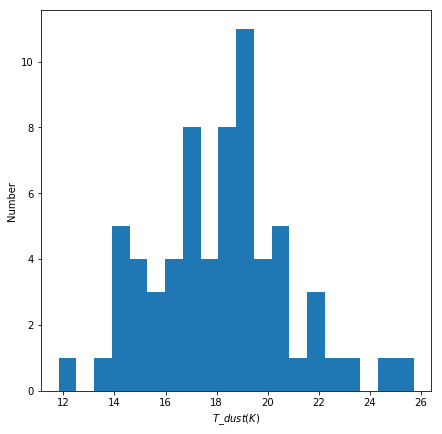

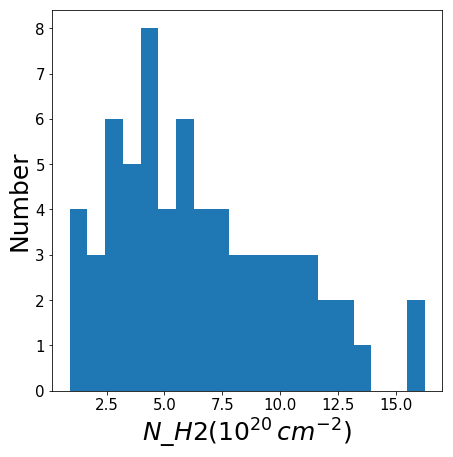

In [13]:
td=[]
nh2=[]
for i in range(len(jps_cat)):
    td.append(jps_cat['T\_dust'][i])
    nh2.append(jps_cat['N\_H2'][i])
    
# the histogram of the data
fig=plt.figure(figsize=(7,7))
plt.hist(td,20)


plt.xlabel(r'$T\_dust (K)$')
plt.ylabel('Number')


plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)
plt.rc('axes', labelsize=25)

fig=plt.figure(figsize=(7,7))
# the histogram of the data
plt.hist(nh2,20)

plt.xlabel(r'$N\_H2 (10^{20}\,cm^{-2})$')
plt.ylabel('Number')

plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)
plt.rc('axes', labelsize=20)

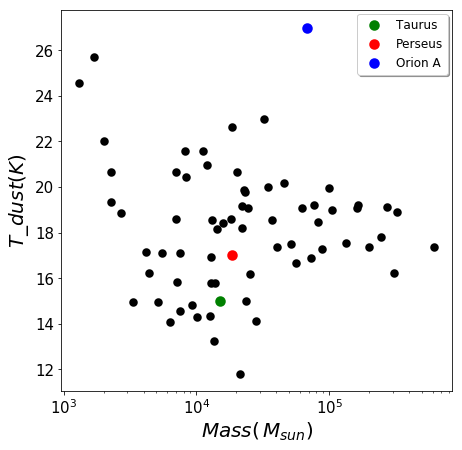

In [14]:
r_pc=[]
for i in range(len(jps_cat)):
    r=np.sqrt(jps_cat['maj'][i]*jps_cat['min'][i])*800.*1000./206265.
    r_pc.append('%.2f' % r)

mass=[]
for i in range(len(r_pc)):
    m=np.pi * (r_pc[i]*u.pc)**2 * (nh2[i]*mu*m_H*(1*10**20))*u.g/(u.cm**2)
    mass.append('%.2f' % (m.to_value(u.M_sun)))

mass_sec=np.ones_like(td)
for i in range(0,len(mass)):
    mass_sec[i]=float(mass[i])
    
mass_other=[]
for i in range(len(r_pc)):
    m=np.pi * (r_pc[i]*u.pc)**2 * (nh2[i]*mu*m_H*(1*10**20))*u.g/(u.cm**2)
    mass_other.append('%.2e' % (m.to_value(u.M_sun)))
    
#plot the fit result
#build the frame of the graph
fig, ax = plt.subplots(figsize=(7,7))
#plt.xlim(10,1000)
#plt.ylim(10,200000)
#plt.yscale('log')
ax.set_xscale('log')

ax.set_xlabel(r'$Mass (\,M_{sun})$')
ax.set_ylabel(r'$T\_dust (K)$')


#plot the data and function
ax.plot(mass_sec,td,'k.',mew=2,markersize=13.)
ax.plot(14964,15,'g.',mew=2,markersize=17.,label='Taurus')
ax.plot(18438,17,'r.',mew=2,markersize=17.,label='Perseus')
ax.plot(67714,27,'b.',mew=2,markersize=17.,label='Orion A')
legend = fig.legend(bbox_to_anchor=(0.90, 0.877), shadow=True, fontsize='large')

plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)
plt.rc('axes', labelsize=20)

INFO: Setting slices=[0] [aplpy.core]


/Users/shjiao/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/aplpy/labels.py:432: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if self.coord == x or self.axis.apl_tick_positions_world[ipos] > 0:
/Users/shjiao/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/aplpy/normalize.py:115: RuntimeWarning: invalid value encountered in less
  negative = result < 0.


INFO: Auto-setting vmin to -1.373e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.370e+00 [aplpy.core]


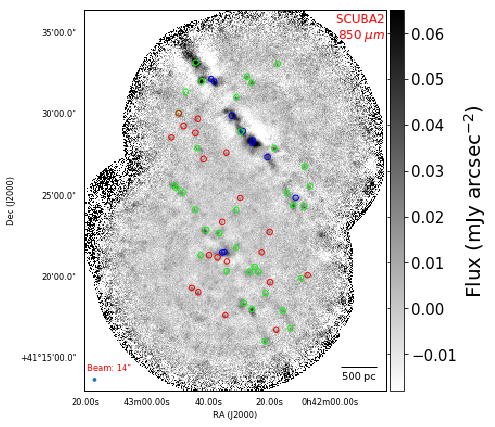

In [15]:
x=[]
y=[]

im_850='/Users/shjiao/desktop/check/sed/data/regird/combined850.sm.fits'

jps_file='/Users/shjiao/desktop/check/m31_850/unsharp_pho_sec.csv'
jps_cat=ascii.read(jps_file)

#open the input file
hdu_850=fits.open(im_850)

for i in range(len(jps_cat)):
    w=wcs.WCS(hdu_850[0].header)
    
    #find pixels that located in the source area
    center_pixel=np.array([[jps_cat['col11'][i],jps_cat['col12'][i]]])
    center_world=w.wcs_pix2world(center_pixel,0)
    x.append(center_world[0][0])
    y.append(center_world[0][1])
    
f_850 = aplpy.FITSFigure('/Users/shjiao/desktop/check/m31_850/m31_850.conv.fits', figsize=(7,7))
f_850.show_grayscale()
f_850.add_colorbar()
f_850.colorbar.show()
f_850.recenter(10.6303042,41.41090276,width=0.31,height=0.39)
f_850.colorbar.set_location('right')
f_850.colorbar.set_axis_label_text(r'Flux (mJy arcsec$^{-2}$)')
f_850.add_label(0.92,0.95, 'SCUBA2 \n850 $\mu m$ ', color='red', relative=True, size='large',layer='source')
f_850.show_colorscale(vmin=-0.006*3,vmax=0.065,cmap='gist_yarg',stretch='linear')
f_850.add_beam(major=14.*u.arcsecond,minor=14.*u.arcsecond,angle=0.0)
f_850.add_label(0.085, 0.06, 'Beam: 14\"', relative=True, size='small', layer='title',color='red')
f_850.tick_labels.set_font(size='small')
f_850.axis_labels.set_font(size='small')
f_850.add_scalebar(0.0367281,"500 pc",color='black', corner='bottom right')
for i in range(len(mass_sec)):
    if mass_sec[i]<10000.:
        f_850.show_markers(x[i],y[i],edgecolor='red')
    elif mass_sec[i]<100000.:
        f_850.show_markers(x[i],y[i],edgecolor='lime')
    else:
        f_850.show_markers(x[i],y[i],edgecolor='blue')


INFO: Setting slices=[0] [aplpy.core]
INFO: Auto-setting vmin to -1.373e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.370e+00 [aplpy.core]


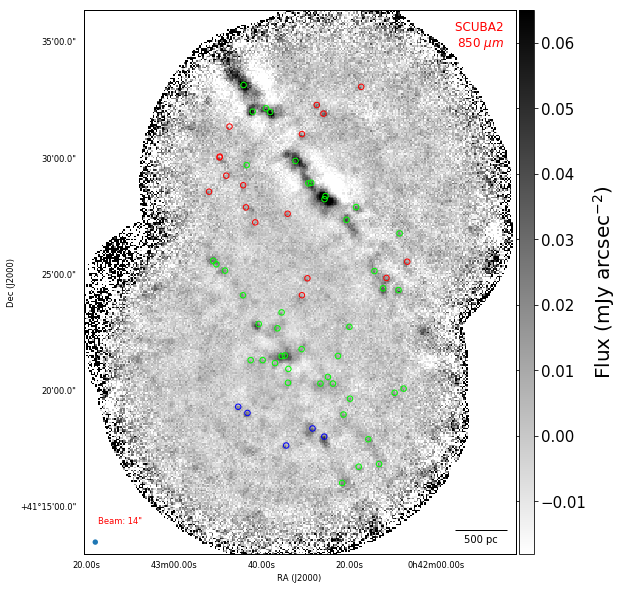

In [16]:
f_850 = aplpy.FITSFigure('/Users/shjiao/desktop/check/m31_850/m31_850.conv.fits', figsize=(10,10))
f_850.show_grayscale()
f_850.add_colorbar()
f_850.colorbar.show()
f_850.recenter(10.6303042,41.41090276,width=0.31,height=0.39)
f_850.colorbar.set_location('right')
f_850.colorbar.set_axis_label_text(r'Flux (mJy arcsec$^{-2}$)')
f_850.add_label(0.92,0.95, 'SCUBA2 \n850 $\mu m$ ', color='red', relative=True, size='large',layer='source')
f_850.show_colorscale(vmin=-0.006*3,vmax=0.065,cmap='gist_yarg',stretch='linear')
f_850.add_beam(major=14.*u.arcsecond,minor=14.*u.arcsecond,angle=0.0)
f_850.add_label(0.085, 0.06, 'Beam: 14\"', relative=True, size='small', layer='title',color='red')
f_850.tick_labels.set_font(size='small')
f_850.axis_labels.set_font(size='small')
f_850.add_scalebar(0.0367281,"500 pc",color='black', corner='bottom right')
for i in range(len(mass_sec)):
    if td[i]<16.5:
        f_850.show_markers(x[i],y[i],edgecolor='red')
    elif td[i]<22.:
        f_850.show_markers(x[i],y[i],edgecolor='lime')
    else:
        f_850.show_markers(x[i],y[i],edgecolor='blue')

In [22]:
td_outarm=[]
mass_outarm=[]
nh2_outarm=[]
x_outarm=[]
y_outarm=[]

for i in range(len(mass_sec)):
    if td[i]<16.2:
        td_outarm.append(td[i])
        mass_outarm.append(mass_sec[i])
        nh2_outarm.append(nh2[i])
        x_outarm.append(x[i])
        y_outarm.append(y[i])
        
td_outarm.append(td[33])
mass_outarm.append(mass_sec[33])
nh2_outarm.append(nh2[33])
x_outarm.append(x[33])
y_outarm.append(y[33])

td_outarm.append(td[44])
mass_outarm.append(mass_sec[44])
nh2_outarm.append(nh2[44])
x_outarm.append(x[44])
y_outarm.append(y[44])

td_outarm.append(td[8])
mass_outarm.append(mass_sec[8])
nh2_outarm.append(nh2[8])
x_outarm.append(x[8])
y_outarm.append(y[8])

td_outarm.append(td[9])
mass_outarm.append(mass_sec[9])
nh2_outarm.append(nh2[9])
x_outarm.append(x[9])
y_outarm.append(y[9])

td_outarm.append(td[21])
mass_outarm.append(mass_sec[21])
nh2_outarm.append(nh2[21])
x_outarm.append(x[21])
y_outarm.append(y[21])

td_outarm.append(td[61])
mass_outarm.append(mass_sec[61])
nh2_outarm.append(nh2[61])
x_outarm.append(x[61])
y_outarm.append(y[61])

INFO: Auto-setting vmin to -5.439e+00 [aplpy.core]
INFO: Auto-setting vmax to  8.636e+01 [aplpy.core]


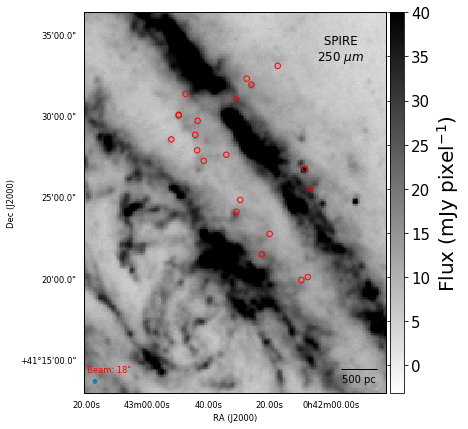

In [23]:
f_250 = aplpy.FITSFigure('/Users/shjiao/desktop/spire250.conv_cutad.fits', figsize=(7,7))
f_250.show_grayscale()
f_250.add_colorbar()
f_250.colorbar.show()
f_250.recenter(10.6303042,41.41090276,width=0.31,height=0.39)
f_250.colorbar.set_location('right')
f_250.colorbar.set_axis_label_text(r'Flux (mJy pixel$^{-1}$)')
f_250.add_label(0.85,0.9, ' SPIRE \n250 $\mu m$', color='black', relative=True, size='large',layer='source')
f_250.show_colorscale(vmin=-3.1211644,vmax=40.,cmap='gist_yarg')
f_250.add_beam(major=18.*u.arcsecond,minor=18.*u.arcsecond,angle=0.0)
f_250.add_label(0.085, 0.06, 'Beam: 18\"', relative=True, size='small', layer='title',color='red')
f_250.tick_labels.set_font(size='small')
f_250.axis_labels.set_font(size='small')
f_250.add_scalebar(0.0367281,"500 pc",color='black', corner='bottom right')
for i in range(len(mass_outarm)):
    f_250.show_markers(x_outarm[i],y_outarm[i],edgecolor='red')

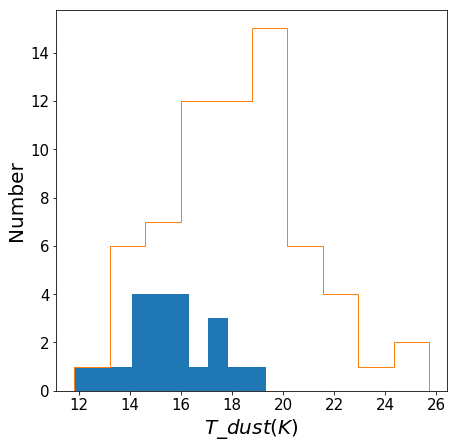

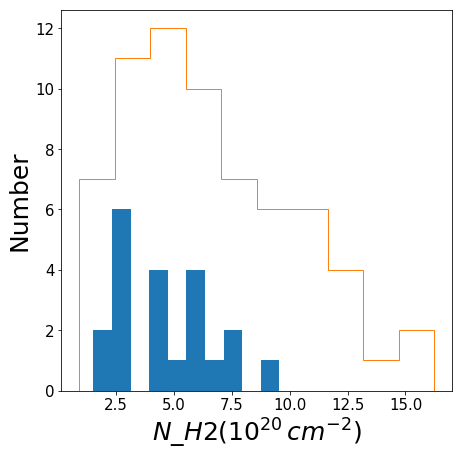

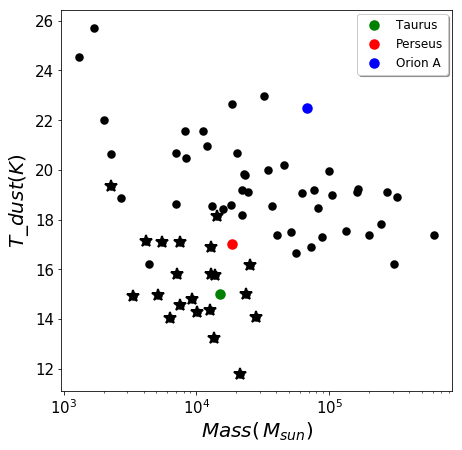

In [24]:
# the histogram of the data
fig=plt.figure(figsize=(7,7))
plt.hist(td_outarm,10)
plt.hist(td,10,histtype='step')


plt.xlabel(r'$T\_dust (K)$')
plt.ylabel('Number')


plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)
plt.rc('axes', labelsize=25)

plt.savefig('/Users/shjiao/desktop/td.pdf')

fig=plt.figure(figsize=(7,7))
# the histogram of the data
plt.hist(nh2_outarm,10)
plt.hist(nh2,10,histtype='step')

plt.xlabel(r'$N\_H2 (10^{20}\,cm^{-2})$')
plt.ylabel('Number')

plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)
plt.rc('axes', labelsize=20)

plt.savefig('/Users/shjiao/desktop/nh2.pdf')

#plot the fit result
#build the frame of the graph
fig, ax = plt.subplots(figsize=(7,7))
#plt.xlim(10,1000)
#plt.ylim(10,200000)
#plt.yscale('log')
ax.set_xscale('log')

ax.set_xlabel(r'$Mass (\,M_{sun})$')
ax.set_ylabel(r'$T\_dust (K)$')


#plot the data and function
ax.plot(mass_sec,td,'k.',mew=2,markersize=13.)
ax.plot(mass_outarm,td_outarm,'k*',mew=2,markersize=13.)
ax.plot(14964,15,'g.',mew=2,markersize=17.,label='Taurus')
ax.plot(18438,17,'r.',mew=2,markersize=17.,label='Perseus')
ax.plot(67714,22.5,'b.',mew=2,markersize=17.,label='Orion A')
legend = fig.legend(bbox_to_anchor=(0.90, 0.877), shadow=True, fontsize='large')

plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)
plt.rc('axes', labelsize=20)


Smooth the image to lower resolution and then do the subtracton. 
Smooth the combined image to 30", 1' and 2'.

In [15]:
#import combined 850 um image
com_file='/Users/shjiao/desktop/combined850.fits'
hdu1=fits.open(com_file)
data1 = hdu1[0].data
data1 = np.nan_to_num(data1)
header = hdu1[0].header

nra = header['naxis1']
ndec = header['naxis2']
#header.remove('CTYPE3')
#header.remove('CRVAL3')
#header.remove('CDELT3')
#header.remove('CRPIX3')
#header.remove('CUNIT3')
#header.remove('NAXIS3')
#header.remove('LBOUND3')
header['NAXIS']=2

target_resolution1 = 30.
target_resolution2 = 60.
target_resolution3 = 120.
native_beamsize = 14.
pixel_size = 4.0

FWHM_TO_SIGMA = 1./np.sqrt(8*np.log(2))

#smooth to 30"
kernel_size1=((target_resolution1*FWHM_TO_SIGMA)**2-(native_beamsize*FWHM_TO_SIGMA)**2)**0.5
pixel_n1 = kernel_size1/pixel_size
gauss_kernel1 =Gaussian2DKernel(pixel_n1)
smoothed_data_gauss1 = convolve(data1, gauss_kernel1,normalize_kernel=True)

#save fits file
outpath1 = r'/Users/shjiao/desktop/check/m31_850/combined_m31_sm1.fits'

fits.writeto(outpath1,smoothed_data_gauss1,header=header) 
fits.setval(outpath1,'BMAJ',value=target_resolution1/3600.)  
fits.setval(outpath1,'BMIN',value=target_resolution1/3600.) 

#smooth to 60"
kernel_size2=((target_resolution2*FWHM_TO_SIGMA)**2-(native_beamsize*FWHM_TO_SIGMA)**2)**0.5
pixel_n2 = kernel_size2/pixel_size
gauss_kernel2 =Gaussian2DKernel(pixel_n2)
smoothed_data_gauss2 = convolve(data1, gauss_kernel2,normalize_kernel=True)

#save fits file
outpath2 = r'/Users/shjiao/desktop/check/m31_850/combined_m31_sm2.fits'

fits.writeto(outpath2,smoothed_data_gauss2,header=header) 
fits.setval(outpath2,'BMAJ',value=target_resolution2/3600.)  
fits.setval(outpath2,'BMIN',value=target_resolution2/3600.) 

#smooth to 120"
kernel_size3=((target_resolution3*FWHM_TO_SIGMA)**2-(native_beamsize*FWHM_TO_SIGMA)**2)**0.5
pixel_n3 = kernel_size3/pixel_size
gauss_kernel3 =Gaussian2DKernel(pixel_n3)
smoothed_data_gauss3 = convolve(data1, gauss_kernel3,normalize_kernel=True)

#save fits file
outpath3 = r'/Users/shjiao/desktop/check/m31_850/combined_m31_sm3.fits'

fits.writeto(outpath3,smoothed_data_gauss3,header=header) 
fits.setval(outpath3,'BMAJ',value=target_resolution3/3600.)  
fits.setval(outpath3,'BMIN',value=target_resolution3/3600.) 

Show the smoothed images

INFO: Auto-setting vmin to -3.130e-02 [aplpy.core]
INFO: Auto-setting vmax to  3.268e-02 [aplpy.core]
INFO: Auto-setting vmin to -1.309e-02 [aplpy.core]
INFO: Auto-setting vmax to  2.002e-02 [aplpy.core]
INFO: Auto-setting vmin to -1.117e-03 [aplpy.core]
INFO: Auto-setting vmax to  1.351e-02 [aplpy.core]


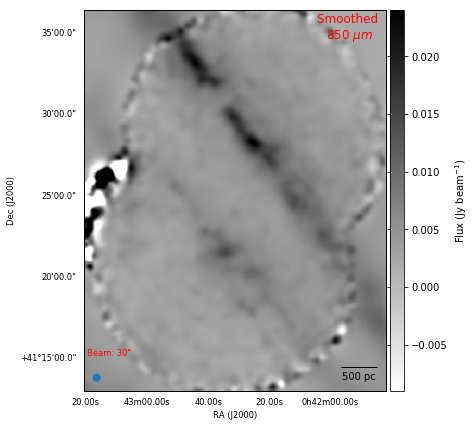

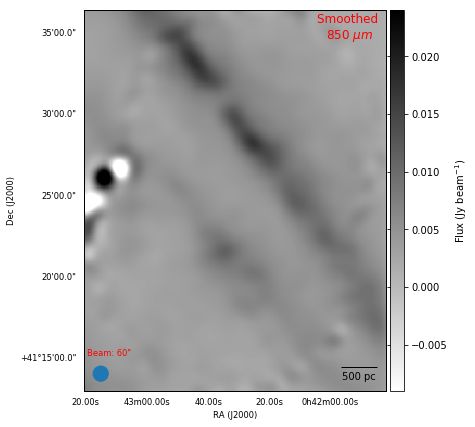

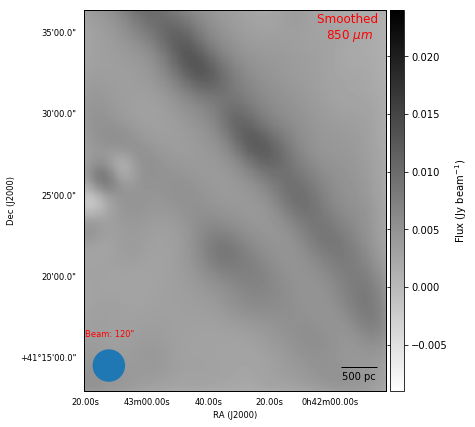

In [21]:
f_sm1 = aplpy.FITSFigure('/Users/shjiao/desktop/check/m31_850/combined_m31_sm1.fits', figsize=(7,7))
f_sm1.show_grayscale()
f_sm1.add_colorbar()
f_sm1.colorbar.show()
f_sm1.recenter(10.6303042,41.41090276,width=0.31,height=0.39)
f_sm1.colorbar.set_location('right')
f_sm1.colorbar.set_axis_label_text(r'Flux (Jy beam$^{-1}$)')
f_sm1.add_label(0.88,0.95, 'Smoothed \n850 $\mu m$ ', color='red', relative=True, size='large',layer='source')
f_sm1.show_colorscale(vmin=-0.003*3,vmax=0.024,cmap='gist_yarg',stretch='linear')
f_sm1.add_beam(major=30.*u.arcsecond,minor=30.*u.arcsecond,angle=0.0)
f_sm1.add_label(0.085, 0.1, 'Beam: 30\"', relative=True, size='small', layer='title',color='red')
f_sm1.tick_labels.set_font(size='small')
f_sm1.axis_labels.set_font(size='small')
f_sm1.add_scalebar(0.0367281,"500 pc",color='black', corner='bottom right')

f_sm2 = aplpy.FITSFigure('/Users/shjiao/desktop/check/m31_850/combined_m31_sm2.fits', figsize=(7,7))
f_sm2.show_grayscale()
f_sm2.add_colorbar()
f_sm2.colorbar.show()
f_sm2.recenter(10.6303042,41.41090276,width=0.31,height=0.39)
f_sm2.colorbar.set_location('right')
f_sm2.colorbar.set_axis_label_text(r'Flux (Jy beam$^{-1}$)')
f_sm2.add_label(0.88,0.95, 'Smoothed \n850 $\mu m$ ', color='red', relative=True, size='large',layer='source')
f_sm2.show_colorscale(vmin=-0.003*3,vmax=0.024,cmap='gist_yarg',stretch='linear')
f_sm2.add_beam(major=60.*u.arcsecond,minor=60.*u.arcsecond,angle=0.0)
f_sm2.add_label(0.085, 0.1, 'Beam: 60\"', relative=True, size='small', layer='title',color='red')
f_sm2.tick_labels.set_font(size='small')
f_sm2.axis_labels.set_font(size='small')
f_sm2.add_scalebar(0.0367281,"500 pc",color='black', corner='bottom right')

f_sm3 = aplpy.FITSFigure('/Users/shjiao/desktop/check/m31_850/combined_m31_sm3.fits', figsize=(7,7))
f_sm3.show_grayscale()
f_sm3.add_colorbar()
f_sm3.colorbar.show()
f_sm3.recenter(10.6303042,41.41090276,width=0.31,height=0.39)
f_sm3.colorbar.set_location('right')
f_sm3.colorbar.set_axis_label_text(r'Flux (Jy beam$^{-1}$)')
f_sm3.add_label(0.88,0.95, 'Smoothed \n850 $\mu m$ ', color='red', relative=True, size='large',layer='source')
f_sm3.show_colorscale(vmin=-0.003*3,vmax=0.024,cmap='gist_yarg',stretch='linear')
f_sm3.add_beam(major=120.*u.arcsecond,minor=120.*u.arcsecond,angle=0.0)
f_sm3.add_label(0.085, 0.15, 'Beam: 120\"', relative=True, size='small', layer='title',color='red')
f_sm3.tick_labels.set_font(size='small')
f_sm3.axis_labels.set_font(size='small')
f_sm3.add_scalebar(0.0367281,"500 pc",color='black', corner='bottom right')

Subtraction

In [28]:
#import combined 850 um image
com_file='/Users/shjiao/desktop/combined850.fits'
hdu1=fits.open(com_file)
data1 = hdu1[0].data
#import scuba2 850 um image
beam_file='/Users/shjiao/desktop/check/m31_850/m31_850.conv.fits'
hdu2=fits.open(beam_file)
data2 = hdu2[0].data[0]

for i in range(0,data2.shape[0]):
    for j in range(0,data2.shape[1]):
        if np.isnan(data2[i][j]):
            data1[i][j]=np.NAN

outpath = r'/Users/shjiao/desktop/check/m31_850/combined_m31_mask.fits'
fits.writeto(outpath,data1,header=header)

#30"
unsharped1=data1-smoothed_data_gauss1
for i in range(0,data2.shape[0]):
    for j in range(0,data2.shape[1]):
        if np.isnan(data2[i][j]):
            unsharped1[i][j]=np.NAN

outpath1 = r'/Users/shjiao/desktop/check/m31_850/combined_m31_unsharped1.fits'
fits.writeto(outpath1,unsharped1,header=header)

#60"
unsharped2=data1-smoothed_data_gauss2
for i in range(0,data2.shape[0]):
    for j in range(0,data2.shape[1]):
        if np.isnan(data2[i][j]):
            unsharped2[i][j]=np.NAN

outpath2 = r'/Users/shjiao/desktop/check/m31_850/combined_m31_unsharped2.fits'
fits.writeto(outpath2,unsharped2,header=header)

#120"
unsharped3=data1-smoothed_data_gauss3
for i in range(0,data2.shape[0]):
    for j in range(0,data2.shape[1]):
        if np.isnan(data2[i][j]):
            unsharped3[i][j]=np.NAN

outpath3 = r'/Users/shjiao/desktop/check/m31_850/combined_m31_unsharped3.fits'
fits.writeto(outpath3,unsharped3,header=header)

Show the unsharp masking images

INFO: Auto-setting vmin to -2.597e-01 [aplpy.core]
INFO: Auto-setting vmax to  2.657e-01 [aplpy.core]
INFO: Auto-setting vmin to -2.505e-01 [aplpy.core]
INFO: Auto-setting vmax to  2.552e-01 [aplpy.core]
INFO: Auto-setting vmin to -2.639e-01 [aplpy.core]
INFO: Auto-setting vmax to  2.649e-01 [aplpy.core]
INFO: Auto-setting vmin to -2.620e-01 [aplpy.core]
INFO: Auto-setting vmax to  2.623e-01 [aplpy.core]


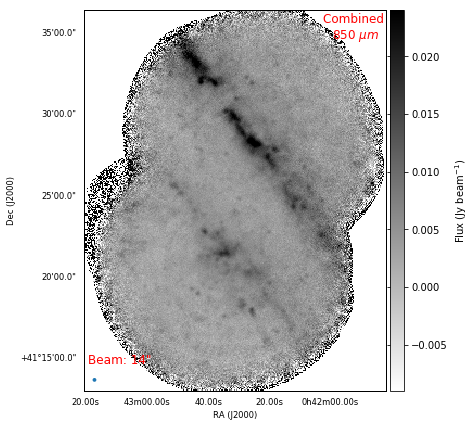

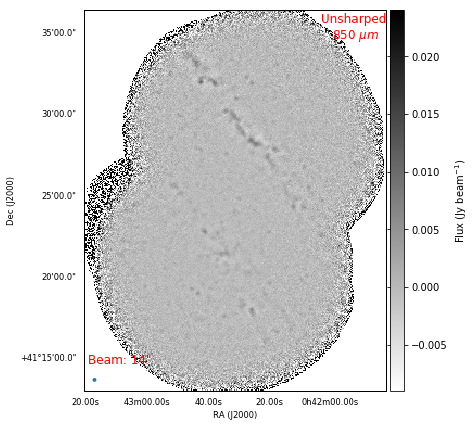

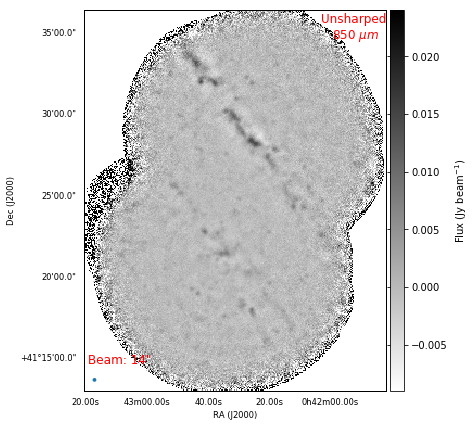

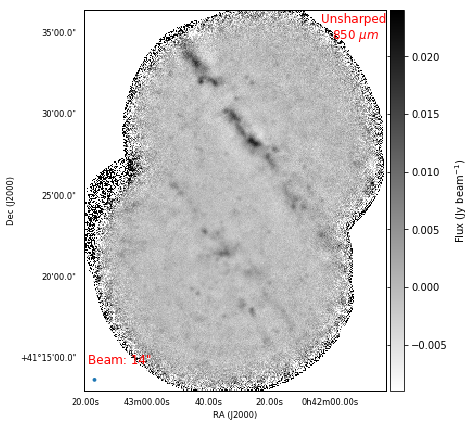

In [34]:
f_850com = aplpy.FITSFigure('/Users/shjiao/desktop/check/m31_850/combined_m31_mask.fits', figsize=(7,7))
f_850com.show_grayscale()
f_850com.add_colorbar()
f_850com.colorbar.show()
f_850com.recenter(10.6303042,41.41090276,width=0.31,height=0.39)
f_850com.colorbar.set_location('right')
f_850com.colorbar.set_axis_label_text(r'Flux (Jy beam$^{-1}$)')
f_850com.add_label(0.9,0.95, 'Combined \n850 $\mu m$ ', color='red', relative=True, size='large',layer='source')
f_850com.show_colorscale(vmin=-0.003*3,vmax=0.024,cmap='gist_yarg',stretch='linear')
f_850com.add_beam(major=14.*u.arcsecond,minor=14.*u.arcsecond,angle=0.0)
f_850com.add_label(0.12, 0.08, 'Beam: 14\"', relative=True, size='large', layer='title',color='red')
f_850com.tick_labels.set_font(size='small')
f_850com.axis_labels.set_font(size='small')

f_850com = aplpy.FITSFigure('/Users/shjiao/desktop/check/m31_850/combined_m31_unsharped1.fits', figsize=(7,7))
f_850com.show_grayscale()
f_850com.add_colorbar()
f_850com.colorbar.show()
f_850com.recenter(10.6303042,41.41090276,width=0.31,height=0.39)
f_850com.colorbar.set_location('right')
f_850com.colorbar.set_axis_label_text(r'Flux (Jy beam$^{-1}$)')
f_850com.add_label(0.9,0.95, 'Unsharped \n850 $\mu m$ ', color='red', relative=True, size='large',layer='source')
f_850com.show_colorscale(vmin=-0.003*3,vmax=0.024,cmap='gist_yarg',stretch='linear')
f_850com.add_beam(major=14.*u.arcsecond,minor=14.*u.arcsecond,angle=0.0)
f_850com.add_label(0.12, 0.08, 'Beam: 14\"', relative=True, size='large', layer='title',color='red')
f_850com.tick_labels.set_font(size='small')
f_850com.axis_labels.set_font(size='small')

f_850com = aplpy.FITSFigure('/Users/shjiao/desktop/check/m31_850/combined_m31_unsharped2.fits', figsize=(7,7))
f_850com.show_grayscale()
f_850com.add_colorbar()
f_850com.colorbar.show()
f_850com.recenter(10.6303042,41.41090276,width=0.31,height=0.39)
f_850com.colorbar.set_location('right')
f_850com.colorbar.set_axis_label_text(r'Flux (Jy beam$^{-1}$)')
f_850com.add_label(0.9,0.95, 'Unsharped \n850 $\mu m$ ', color='red', relative=True, size='large',layer='source')
f_850com.show_colorscale(vmin=-0.003*3,vmax=0.024,cmap='gist_yarg',stretch='linear')
f_850com.add_beam(major=14.*u.arcsecond,minor=14.*u.arcsecond,angle=0.0)
f_850com.add_label(0.12, 0.08, 'Beam: 14\"', relative=True, size='large', layer='title',color='red')
f_850com.tick_labels.set_font(size='small')
f_850com.axis_labels.set_font(size='small')

f_850com = aplpy.FITSFigure('/Users/shjiao/desktop/check/m31_850/combined_m31_unsharped3.fits', figsize=(7,7))
f_850com.show_grayscale()
f_850com.add_colorbar()
f_850com.colorbar.show()
f_850com.recenter(10.6303042,41.41090276,width=0.31,height=0.39)
f_850com.colorbar.set_location('right')
f_850com.colorbar.set_axis_label_text(r'Flux (Jy beam$^{-1}$)')
f_850com.add_label(0.9,0.95, 'Unsharped \n850 $\mu m$ ', color='red', relative=True, size='large',layer='source')
f_850com.show_colorscale(vmin=-0.003*3,vmax=0.024,cmap='gist_yarg',stretch='linear')
f_850com.add_beam(major=14.*u.arcsecond,minor=14.*u.arcsecond,angle=0.0)
f_850com.add_label(0.12, 0.08, 'Beam: 14\"', relative=True, size='large', layer='title',color='red')
f_850com.tick_labels.set_font(size='small')
f_850com.axis_labels.set_font(size='small')